**ogs@jupyter-lab: Transport of a conservative tracer in diffusion-controlled conditions**

<table><tr>
<td> <img src="../ogs-workflows.png" alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="../icross-logo-ok.png" alt="Drawing" style="width: 100px;"/> </td>
</tr></table>

OGS models are written in project files `.prj` (which are valid `XML` files). The project file structure is given by `keywords`:
```XML
<OpenGeoSysProject>
    <meshes>
       ...
    </meshes>
    <processes>
        <process>
            <name>hc</name>
            <type>ComponentTransport</type>
             ...
        </process>
    </processes>
    <media>
        ...
    </media>
    <time_loop>
        ...
    </time_loop>
    <parameters>
        ...
    </parameters>
    <process_variables>
        <process_variable>
            ...
            <initial_condition>...</initial_condition>
            <boundary_conditions>
                ...
            </boundary_conditions>
        </process_variable>
    </process_variables>
</OpenGeoSysProject>
```

Each keyword is used to control different aspects of the model conditions. The complete project file of the conservative tracer diffusion can be viewed (and edited) by opening the file `tracer.prj` and selecting `XML` as format (bottom left corner) in jupyter-lab. 

Sometimes it is useful to validate the project files to catch syntax errors. This can be done with `xmllint` (included in the ogs-serial-jupyter container):

In [24]:
!xmllint --noout tracer.prj

After writting and validating the project file, there are a few steps to follow before running the OGS model, which are explained in the following. 

### ***1) OGS pre-processing utilities***

First, the mesh file generated with an external tool (GMSH `*.msh`) is converted to `*.vtu` format (compatible with OGS) via the `GMSH2OGS` utility. Then nodes are reordered (may not always be necessary) and, finally, meshes are constructed for boundary conditions with `constructMeshesFromGeometry`, where a `*.gml` OGS geometry file is needed:

```XML
<?xml version="1.0" encoding="ISO-8859-1"?>
<OpenGeoSysGLI>
    <name>opa</name>
    <points>
        <point id="0" x="0.0" y="0" z="0" name="left"/>
        <point id="1" x="20.0" y="0" z="0" name="right"/>
    </points>
</OpenGeoSysGLI>
```

**Note:** `import os` allows to run terminal commands inside the notebook (included in the ogs-serial-jupyter container image).

In [25]:
import os
mesh = "opa"
os.system("GMSH2OGS -e -i {}.msh -o {}.vtu".format(mesh, mesh))
os.system("NodeReordering -i {}.vtu -o {}.vtu".format(mesh, mesh))
os.system("constructMeshesFromGeometry -m {}.vtu -g {}.gml -s 1e-6".format(mesh, mesh))

[2021-11-30 15:49:09.457] [ogs] [info] Reading opa.msh.
[2021-11-30 15:49:09.457] [ogs] [info] 	... finished.
[2021-11-30 15:49:09.457] [ogs] [info] Nr. Nodes: 51.
[2021-11-30 15:49:09.457] [ogs] [info] Nr. Elements: 50.
[2021-11-30 15:49:09.457] [ogs] [info] Mem for mesh: 0 MiB
[2021-11-30 15:49:09.457] [ogs] [info] Time for reading: 0.000205 seconds.
[2021-11-30 15:49:09.457] [ogs] [info] Read 51 nodes and 50 elements.
[2021-11-30 15:49:09.457] [ogs] [info] Removing total 50 elements...
[2021-11-30 15:49:09.457] [ogs] [info] 0 elements remain in mesh.
[2021-11-30 15:49:09.457] [ogs] [info] Removing total 51 nodes...
[2021-11-30 15:49:09.457] [ogs] [info] Current selection removes all elements.
[2021-11-30 15:49:09.457] [ogs] [info] Mesh does not contain any lines.
[2021-11-30 15:49:09.457] [ogs] [info] Please check your mesh carefully!
[2021-11-30 15:49:09.457] [ogs] [info] Degenerated or redundant mesh elements can cause OGS to stop or misbehave.
[2021-11-30 15:49:09.457] [ogs] [inf

0

### ***2) Running OGS with `ogs6py`***

The `ogs-serial-jupyter` container is preloaded with the Python API `ogs6py` that allows, among other things, to run OGS models in the notebook. First, the package is imported into the session, and then a model is created with the `ogs.OGS` function (indicating the project file `tracer.prj` in this case). After that, the model is simulated with the `run_model` function.

In [26]:
from ogs6py import ogs

# check if output directory exists
output_dir = "output"
check_output_dir = os.path.isdir(output_dir)
if not check_output_dir:
    os.makedirs(output_dir)
    print(">>> created output directory: ", output_dir)
else:
    print(output_dir, "directory already exists.")

model = ogs.OGS(PROJECT_FILE="tracer.prj")
print(">>> model running <<<")
model.run_model(write_logs=False, args="-o ./{}".format(output_dir))

output directory already exists.
>>> model running <<<
OGS finished with project file tracer.prj.
Execution took 0.49863195419311523 s


The above command writes the model output in the subfolder `output` witht the option `args="-o ./output"` (if this is not entered, the output will be written in the same location as the `.prj` file). No log file is created. To generate a log file, the argument `write_logs` can be removed (note that the model log is written into a text file `out` by default). 

### ***3) Get model output with `vtuIO` (post-processing)***

`vtuIO` is a Python package created to extract the model output from the generated `.vtu` files by OGS. The package is simply imported into the session along with other Python data manipulation and plotting tools (`numpy` and `matplotlib`). Other Python packages for this purpose can be used (they can be installed in a terminal using the Launcher via `pip` or in a cell with `!pip install <package>` but won't be saved after closing the session!).  

>>> print results <<<


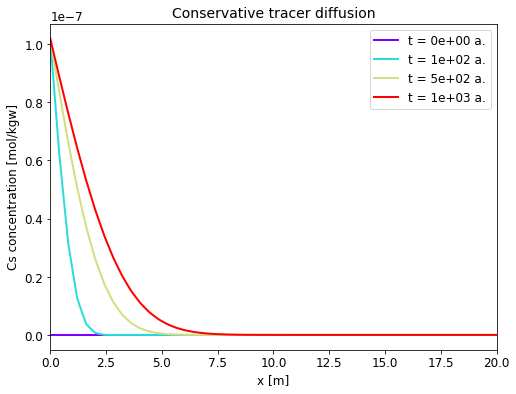

In [27]:
import vtuIO
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

plt.style.use('../notebook.mplstyle')
print(">>> print results <<<")

pvdfile=vtuIO.PVDIO("./output/out.pvd", dim=1)

xaxis =  [(i,0,0) for i in np.linspace(start=0.0, stop=20, num=100)]
r_x = np.array(xaxis)[:,0]
time = [0,3153600000,15768000000,31536000000]

color=iter(cm.rainbow(np.linspace(0,1,len(time))))
for t, color in zip(time, color):
    function_xaxis_t = pvdfile.read_set_data(t, 'Cs', pointsetarray=xaxis)
    plt.plot(r_x, function_xaxis_t, label='t = {:.0e} a.'.format(t/365/3600/24), color=color)
    
plt.title("Conservative tracer diffusion")
#plt.xscale('log')
plt.xlim(0,20)
plt.xlabel('x [m]')
plt.ylabel('Cs concentration [mol/kgw]')

plt.legend()

plt.show()

### ***4) Alternative mesh density***

To show an additinal setup with a finer mesh element size (0.05 vs 0.4 m in the previous setup), an additional model can be run in the same notebook. First, a new mesh `opa-fine.msh` is converted to `.vtu` format:

In [28]:
mesh = "opa-fine"
os.system("GMSH2OGS -e -i {}.msh -o {}.vtu".format(mesh, mesh))
os.system("NodeReordering -i {}.vtu -o {}.vtu".format(mesh, mesh))

[2021-11-30 15:49:10.705] [ogs] [info] Reading opa-fine.msh.
[2021-11-30 15:49:10.706] [ogs] [info] 	... finished.
[2021-11-30 15:49:10.706] [ogs] [info] Nr. Nodes: 401.
[2021-11-30 15:49:10.706] [ogs] [info] Nr. Elements: 400.
[2021-11-30 15:49:10.706] [ogs] [info] Mem for mesh: 0 MiB
[2021-11-30 15:49:10.706] [ogs] [info] Time for reading: 0.000652 seconds.
[2021-11-30 15:49:10.706] [ogs] [info] Read 401 nodes and 400 elements.
[2021-11-30 15:49:10.706] [ogs] [info] Removing total 400 elements...
[2021-11-30 15:49:10.706] [ogs] [info] 0 elements remain in mesh.
[2021-11-30 15:49:10.706] [ogs] [info] Removing total 401 nodes...
[2021-11-30 15:49:10.706] [ogs] [info] Current selection removes all elements.
[2021-11-30 15:49:10.706] [ogs] [info] Mesh does not contain any lines.
[2021-11-30 15:49:10.706] [ogs] [info] Please check your mesh carefully!
[2021-11-30 15:49:10.706] [ogs] [info] Degenerated or redundant mesh elements can cause OGS to stop or misbehave.
[2021-11-30 15:49:10.706]

0

Then, a new OGS model is created with the `tracer-fine.prj` project file. This project is a copy of `tracer.prj` but indicating the use of the new fine mesh `opa-fine.vtu`. 

In [29]:
model_fine = ogs.OGS(PROJECT_FILE="tracer-fine.prj")
print(">>> model running <<<")
model_fine.run_model(write_logs=False, args="-o ./{}".format(output_dir))

>>> model running <<<
OGS finished with project file tracer-fine.prj.
Execution took 2.8875980377197266 s


Then results can be compared:

>>> print results <<<


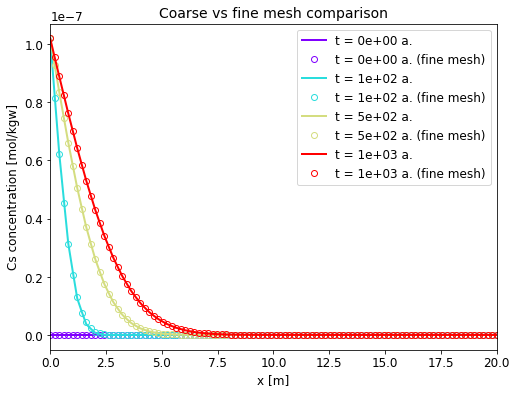

In [30]:
print(">>> print results <<<")

pvdfile_fine=vtuIO.PVDIO("./output/out_fine.pvd", dim=1)
time = [0, 3153600000,15768000000,31536000000]

color=iter(cm.rainbow(np.linspace(0,1,len(time))))
for t, color in zip(time, color):
    y = pvdfile.read_set_data(t, 'Cs', pointsetarray=xaxis)
    plt.plot(r_x, y, label='t = {:.0e} a.'.format(t/365/3600/24), color=color, linestyle="-")
    y_fine = pvdfile_fine.read_set_data(t, 'Cs', pointsetarray=xaxis)
    plt.plot(r_x, y_fine, label='t = {:.0e} a. (fine mesh)'.format(t/365/3600/24), color=color,  marker="o", mfc="none", linestyle="")
    
plt.title("Coarse vs fine mesh comparison")
plt.xlim(0,20)
plt.xlabel('x [m]')
plt.ylabel('Cs concentration [mol/kgw]')

plt.legend()
plt.show()